#  Stacking for the estimation of Treatment Effects

##The inherent difficulty of estimating treatment effects
In estimating the effect of a treatment, we would ideally like to know what the outcome $y_i$ would have been, had the treated not received treatment, and had the treated been left untreated.
This is almost always impossible, firstly because of the likely impossibility of time travel. Indeed, we will never be able to set up an experiment where each person in the treatment group has their exact twin in the control group.
But another reason, specifically in marketing, is that a treatment (like a voucher for some online market) may be very expensive to offer to all or even one half of the sample.

In an experimental setup, or a situation in which we have treated and untreated data, it is necessary to estimate the underlying distribution of the 'nuisance variables' $X_i$ as well as the propensity score (the likelihood, given an observation's characteristics, to be treated) $e_i$, in order to be able to extract the effect of the treatment.
^^^maybe talk specifically here about propensity score. or give a really simple example of why its hard to estimate a treatment effect with a skewed treatment group.
^^^i think grimmer has a good quote

# 1. Synthesizing data
For the reasons above, we will synthesize data on which we will carry out stacking experiments, in order to compare the predictive results of our models depending on the shape of the underlying data, and conclude upon the effectiveness of stacking for treatment effects in each situation.
We generate data according to the same process as *Nie X. and Wager S. (2018) 'Quasi-Oracle Estimation of Heterogeneous Treatment Effects'*. a library for generating different kinds of data specifically for the study of treatment effects is provided by `causalml` from uber (https://github.com/uber/causalml).

`causalml` provides an implementation of each data generating function as seen in Nie & Wager, accessible through five possible modes passed to synthetic_data() :

Each of these provides a data set of $X_i$ variables, propensity to be treated $e_i$ as a function of the $X_i$ (or as a random function, in some cases), and a treatment effect as a function of the $X_i$.
Generated datasets also have the advantage that we may generate as much data as we need in order to cross validate and otherwise test, with the guarantee that all the data generated comes from the same distribution. The `causalml` datasets also provide us with the true treatment effect and true outcome without treatment, so that we may be able to test the predicted $y_i$ and $\tau(X_i)$

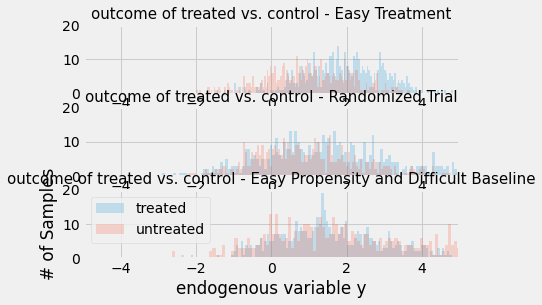

In [5]:
import numpy as np
from causalml.dataset import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from mlens.ensemble import SuperLearner
from sklearn.metrics import r2_score, mean_squared_error
import simple_model
import dataGen
import matplotlib.pyplot as plt

y_easy, X_easy, w_easy, tau_easy, b_easy, e_easy = simulate_nuisance_and_easy_treatment(n=1000, p=5)
y_rand, X_rand, w_rand, tau_rand, b_rand, e_rand = simulate_randomized_trial(n=1000, p=5)
y_difficult, X_difficult, w_difficult, tau_difficult, b_difficult, e_difficult = simulate_easy_propensity_difficult_baseline(
    n=1000, p=5)

dataGen.treated_vs_untreated_plot(y_easy, w_easy, 'Easy Treatment', 311)
dataGen.treated_vs_untreated_plot(y_rand, w_rand, 'Randomized Trial', 312)
dataGen.treated_vs_untreated_plot(y_difficult, w_difficult, 'Easy Propensity and Difficult Baseline', 313)

plt.xlabel('endogenous variable y')
plt.ylabel('# of Samples')
_ = plt.legend()
plt.show()

##TODO: add spacing between these cells or something.

Above we plot the distribution of the outcome variable $y$, and how it differs between the treated and the control groups.
In the 'Setup A' of Nie and Wager - reproducing an easy to estimate treatment effect (from causalml: `y = b + (w - 0.5) * tau + sigma * np.random.normal(size=n)`) we can see that the distribution of the treatment arm is just shifted to the right of the control.
In other setups, however, the difference in the outcome is unclear -- in the 'Easy Propensity and Difficult Baseline' setup, there is no clear treatment effect just examining the distribution of Y. (y = b + (w - 0.5) * tau + sigma * np.random.normal(size=n))
where `e = 1/(1 + np.exp(X[:, 1] + X[:, 2]))`
So we should like to see how different approaches to estimating the underlying X's and the different methods used ot stack them compare over different sets.


# 2. The 'T-Learner', Grimmer et al (2017)

## a literature summary of grimmer :
the find that the ensemble method is better than any single model in all cases, soemtimes much much better.. Used on political data with many categorical variables. (real-life data).

## The T-learner procedure
Nie and Wager estimate treatment effects using (among other heterogeneous treatment effect estimators) the 'T-Learner'. `causalml library also provides a T-learner as used in Grimmer (2017).

where the treatment effect is estimated by simple comparison of the treated against the untreated, with the same underlying $X_i$. This involves training a machine learning model, the 

The T Learner fits the functions $ \mu^*_w(x) = E(Y\mid X = x, W = w)$ separately for the treatment and the control groups (for $w \in{0, 1}$), and then esimates $\tau(x) = \mu_1(x) - \mu_0(x)$
The T learner (`BaseTRegressor()`) as implemented by `causalml` can be fed a machine learning model to estimate and predict treatment effects.
it will therefore be useful to have a stacking pipeline which includes several T-Learners, over different datasets in order to examine how well a Stacked T learner does under different data generating functions.


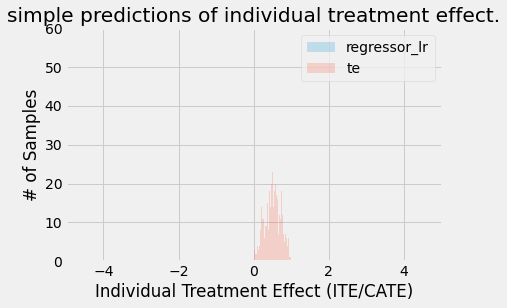

r2 score is:-0.732384392674148
MSE is:0.07055551251874255
r2 score is:-1.2996933879047665
MSE is:0.09366053302357573
r2 score is:-59.699108560486295
MSE is:2.472116888160772
r2 score is:-1.5501790458146822
MSE is:0.10386216266602931
r2 score is:-1.8720198864183963
MSE is:0.11696990339278909


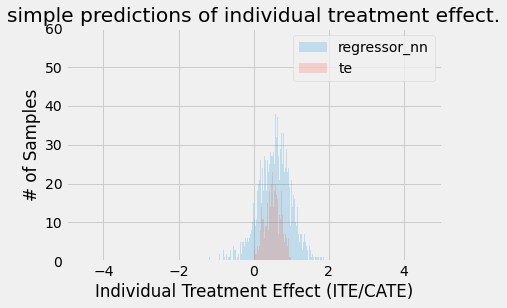

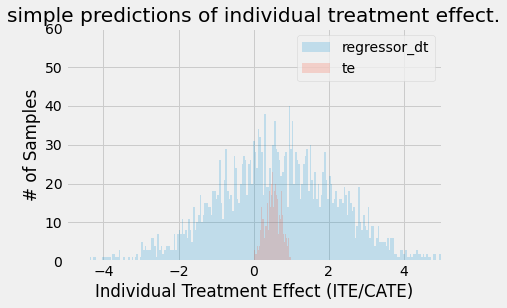

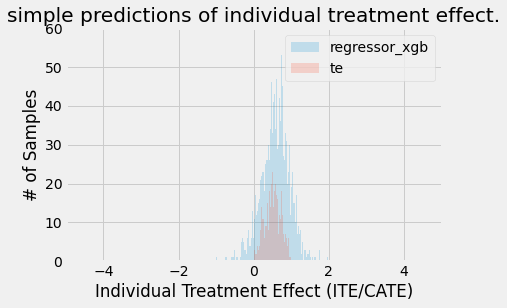

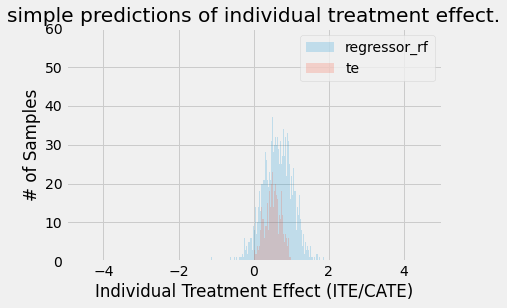

In [6]:
regressors = { 'regressor_lr' :LinearRegression(),
               'regressor_nn': MLPRegressor(),
               'regressor_dt' : DecisionTreeRegressor(),
               'regressor_xgb' : XGBRegressor(),
               'regressor_rf': RandomForestRegressor()}
e_regressors = regressors.copy()

np.random.seed(42)

y_easy, X_easy, w_easy, tau_easy, b_easy, e_easy = simulate_nuisance_and_easy_treatment(n=10000, p=20)

y_easy_train, y_easy_test, X_easy_train, X_easy_test, w_easy_train, w_easy_test, tau_easy_train, tau_easy_test = train_test_split(
y_easy, X_easy, w_easy, tau_easy, test_size=0.25, random_state=42)

easy_preds = simple_model.make_simple_predictions_for_stacking(X_easy_train, X_easy_test, y_easy_train, w_easy_train, regressors)
simple_model.multilayer_hist(easy_preds, tau_easy_test)

In [7]:
ensemble = SuperLearner(scorer=mean_squared_error, random_state=42)
ensemble.add([e_regressors['regressor_rf'], e_regressors['regressor_xgb'], e_regressors['regressor_nn'], e_regressors['regressor_lr']])
ensemble.add_meta(e_regressors['regressor_nn'])

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...3cb7820>)],
   n_jobs=-1, name='group-3', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function mean_squared_error at 0x123cb7820>, shuffle=False,
       verbose=False)

In [8]:
e_preds = simple_model.create_simple_ml_model(X_easy_train, X_easy_test, y_easy_train, w_easy_train, ensemble)

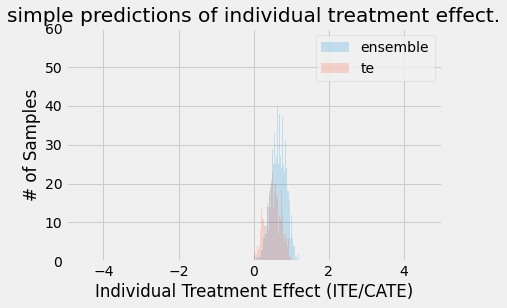

r2 score is:-0.05479174380885077
MSE is:0.042958925513114976


In [9]:
simple_model.multilayer_hist({'ensemble':e_preds}, tau_easy_test)

In [10]:
# import stacking_helpers
# simple_stackimg_model = stacking_helpers.do_stacking(easy_t_preds, tau_easy_t)

# stacking_helpers.plot_stacking_preds(simple_stackimg_model, tau_easy_t)

# mse_dict = stacking_helpers.evaluate_models_compare_to_stacking(easy_t_preds, tau_easy_t, simple_stackimg_model.fittedvalues)
# ##TODO: standardise the predicitons, run the model and get weights, and then try on new data to see if we get any closer to the real model
# ##also print the mse dict!

_write some text on the weights for stacking_

why we cant just use sklearn stacking if we are just treating the treatment var like a dummy var:
OR WE CAN DO STACKING IN THE CASE WHERE WE LEARN THE TREATED AND UNTREATED ARM INDEPENDENTLY. thats how we are predicting anyways.
there are a bunch of different setups/order of operations if we intend to do stacking to use the models as averages

the pipeline for stacking can take many forms when esitmating treatment effects.

also need to mention when we talk about each of the datasets : what is the best possible outcome we can expect from any model? each dataset has its data generating function with more or less randomness introduced.


so now that we have more or less a framework for the simple case of predicting treatment effects and obviously stacking does work ok
we can look at other ways to try stacking while incorporating double machine learning..

the next logical step would be to stack several t learners.
do we think this would work better?

# 2. Learner selection -

## Grimmer et al, the 'T learner' and OLS.

we can use this to stack estimates exactly as in Grimmer, and compare them to the R learners/DML learnings (also stacked) as in Nie, Wager
this would answer the questions:
 - how does stacking **without** double machine learning compare to the R learner on its own? Is there an advantage to using (the best..) R learner over simple stacking? and what kind of libraries are already available for such a pipeline?
 - how much can stacking help if we do not (can not) estimate propensity scores or distinct nuisance functions in the dataset?
 - how does stacking an R learner compare to (the best) single DML model?

the T learner does not explicitly account for propensity scores, or for the 'nuisance funciton' separate from the treatment effect.

the R learner, on the other hand:
 - R leaner, DML, etc etc.
 - The proposal from Nie and Wager for using some 'out of the box models and stacking the treatment effect estimations

The R learner can also be fed different models, and the results similarly stacked.

# 2. Feed in different models

We continue in the methodology of Nie and Wager, (QUOTE), by creating R learners using various methods to estimate the underlying functions for the X variables. 
(for the moment we will always use ElasticNetPropensityModel to estimate propensity scores.)

How many models can we feed in?

In [11]:
from causalml.inference.meta import BaseRRegressor, BaseTRegressor
import statsmodels.api as sm
import copy
import numpy as np

In [12]:
## can start with estimates from the T learner

learner_t_xgb = BaseTRegressor(learner=XGBRegressor())
learner_t_mlpr = BaseTRegressor(learner=MLPRegressor())
learner_t_lr = BaseTRegressor(learner=LinearRegression())

estimators = {'learner_t_xgb' : BaseTRegressor(learner=XGBRegressor()),
              'learner_t_mlpr': BaseTRegressor(learner=MLPRegressor()),
              'learner_t_lr' : BaseTRegressor(learner=LinearRegression())}

predicitons_t_models = get_synthetic_preds(simulate_nuisance_and_easy_treatment,
                                               n=50000,
                                               estimators=estimators)

In [13]:
'''
estimators = {'learner_xgb': BaseRRegressor(learner=XGBRegressor()),
              'learner_lr': BaseRRegressor(learner=LinearRegression()),
              'learner_dtr': BaseRRegressor(learner=DecisionTreeRegressor()),
              'learner_ctr': BaseRRegressor(learner=CausalTreeRegressor()),
              'learner_knr': BaseRRegressor(learner=KNeighborsRegressor()),
              'learner_svr': BaseRRegressor(learner=SVR())}
              '''
###would be cool to find some other working learners, and to start messing with the params of each!!!!
#learner_knr = BaseRRegressor(learner=KNeighborsRegressor())
#learner_svr = BaseRRegressor(learner=SVR())
#learner_ctr = BaseRRegressor(learner=CausalTreeRegressor())
#'learner_sgd': BaseRRegressor(learner=SGDRegressor())
#learner_nnr = BaseRRegressor(learner=MLPRegressor()) ##Multi-layer Perceptron regressor

estimators = {'learner_xgb': BaseRRegressor(learner=XGBRegressor()),
              'learner_lr': BaseRRegressor(learner=LinearRegression()),
              'learner_dtr': BaseRRegressor(learner=DecisionTreeRegressor())}

predictions = get_synthetic_preds(simulate_nuisance_and_easy_treatment,
                                               n=50000,
                                               estimators=estimators)

In [14]:
### THE STADCKING PART (AGAIN.)

y_stacking = predictions['generated_data']['tau']
pred_copy = copy.deepcopy(predictions)
pred_copy.pop('Actuals')
pred_copy.pop('generated_data')

### iterate over this better so you can add mroe models.
x_stacking = np.vstack((predictions['learner_xgb'], predictions['learner_lr'], predictions['learner_dtr'])).T

### this is using ridgeCV for the method of ols.
### grimmer require that the coefficients of the final stacking regression sum to 1.
### HOW CAN WE DO THIS IN SKLEARN WHILE STILL USING CAUSALML?

model = sm.OLS(y_stacking, x_stacking)
model2 = model.fit_regularized(alpha=0.0, L1_wt=1.0, start_params=None, profile_scale=False, refit=False)
print(model2.params)
print(sum(model2.params))

[ 8.15724686e-03  7.32973276e-01 -1.00159168e-04]
0.741030363667315


this is actually a sad shortcoming of the `causalml` library, that it is not possible to feed models directly into sklearn.ensemble models.
normally an ensemble class from sklear woudl take a dict (i think..) of models and a dataset, do the entire pipeline, and then output the model.

if we would like to imitate grimmer we would also need a solution to the problem that we currently dont have a way to contstrain the ensemble coefficients such that they must sum to 1.

In [15]:
predictions_A = get_synthetic_preds(simulate_nuisance_and_easy_treatment, n=50000)
predictions_B = get_synthetic_preds(simulate_randomized_trial, n=50000)
predictions_C = get_synthetic_preds(simulate_easy_propensity_difficult_baseline, n=50000)
predictions_E = get_synthetic_preds(simulate_hidden_confounder, n=50000)

In [16]:
### THE STADCKING PART (AGAIN.)

y_stacking = predictions['generated_data']['tau']
pred_copy = copy.deepcopy(predictions)
pred_copy.pop('Actuals')
pred_copy.pop('generated_data')

### iterate over this better so you can add mroe models.
x_stacking = np.vstack((predictions['learner_xgb'], predictions['learner_lr'], predictions['learner_dtr'])).T

### this is using ridgeCV for the method of ols.
### grimmer require that the coefficients of the final stacking regression sum to 1.
### HOW CAN WE DO THIS IN SKLEARN WHILE STILL USING CAUSALML?

model = sm.OLS(y_stacking, x_stacking)
model2 = model.fit_regularized(alpha=0.0, L1_wt=1.0, start_params=None, profile_scale=False, refit=False)
print(model2.params)
print(sum(model2.params))

[ 8.15724686e-03  7.32973276e-01 -1.00159168e-04]
0.741030363667315


this is actually a sad shortcoming of the `causalml` library, that it is not possible to feed models directly into sklearn.ensemble models.
normally an ensemble class from sklear woudl take a dict (i think..) of models and a dataset, do the entire pipeline, and then output the model.

if we would like to imitate grimmer we would also need a solution to the problem that we currently dont have a way to contstrain the ensemble coefficients such that they must sum to 1.

In [ ]:
predictions_A = get_synthetic_preds(simulate_nuisance_and_easy_treatment, n=50000)
predictions_B = get_synthetic_preds(simulate_randomized_trial, n=50000)
predictions_C = get_synthetic_preds(simulate_easy_propensity_difficult_baseline, n=50000)
predictions_E = get_synthetic_preds(simulate_hidden_confounder, n=50000)